# 1. Importing libraries

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

import math
import time
from pathlib import Path

from openml import tasks, datasets

from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score,recall_score,ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score,RepeatedStratifiedKFold,RandomizedSearchCV,train_test_split
from sklearn import svm
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

    
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from xgboost import XGBClassifier

# 2. Load Datasets

In [19]:
def load_dataset(dataset_source):

    if dataset_source =="HTRU":

        '''
        Orginal data from High Time Resolution Universe (HTRU) 
        Dataset: https://www.openml.org/search?type=data&status=active&id=45558&sort=runs
        ''' 

        # Load the dataset from OpenML
        htru2_dataset = datasets.get_dataset(45558,download_data=False,download_qualities=False,download_features_meta_data=False)
        X, y, _, _ = htru2_dataset.get_data(dataset_format='dataframe', target=htru2_dataset.default_target_attribute)

        y = [int(val) for val in y]

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Split the data into train and temporary test sets
        X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Split the train and validation sets from the temporary train set
        X_train, X_valid, y_train, y_valid = train_test_split(X_train_val, y_train_val, test_size=0.3, random_state=42)

        # Store original column names
        input_columns = X_train.columns

        print("Training Set Shape: ",X_train.shape)
        print("Validation Set Shape: ",X_valid.shape)
        print("Testing Set Shape: ",X_test.shape)

    else:
        # Load the dataset from CSV file
        
        '''
        Data from LOFAR Tied-Array All-Sky Survey (LOTAAS)
        
        Paper: The LOFAR Tied-Array All-Sky Survey (LOTAAS): Survey overview and initial pulsar discoveries
        Sanidas et. al. 
        
        Catalogue: https://vizier.cds.unistra.fr/viz-bin/VizieR?-source=J/A+A/626/A104&-to=3#tablist
        '''

        dataset_filename = "LOTAAS_1_Lyon_Features (8).csv"
        #dataset_filename = "LOTAAS_1_Lyon_Features (8)_10_Bin_Discretized.csv"

        data = pd.read_csv(dataset_filename, header=None, names=['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6', 'feature7', 'feature8', 'class'])

        # Split the  data into features (X) and target (y)
        X = data.iloc[:, :-1].values  # Select all rows and columns except the last column
        y = data.iloc[:, -1].values   # Select all rows and the last column

        # Split the data into train and temporary test sets
        X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Split the train and validation sets from the temporary train set
        X_train, X_valid, y_train, y_valid = train_test_split(X_train_val, y_train_val, test_size=0.3, random_state=42)

        input_columns = data.columns[:-1]
        output_columns = data.columns[-1]

        X_train= pd.DataFrame(X_train)
        X_valid= pd.DataFrame(X_valid)
        X_test = pd.DataFrame(X_test)

        print("Training Set Shape: ",X_train.shape)
        print("Validation Set Shape: ",X_valid.shape)
        print("Testing Set Shape: ",X_test.shape)

        X_train.columns = input_columns
        X_valid.columns = input_columns
        X_test.columns = input_columns
        
    return X_train, X_valid, X_test, y_train, y_valid, y_test, input_columns


In [20]:
 def plot_output_distribution(y_train, y_test):
    # Plot the distributions
    plt.figure(figsize=(8, 6))
    plt.hist(y_train, bins=20, alpha=0.5, label='Training Data')
    plt.hist(y_test, bins=20, alpha=0.5, label='Testing Data')
    plt.title('Distribution of Pulsars(1) and Non Pulsars(0)')
    plt.xlabel('Output Value')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

# 3. Preprocess Data

In [21]:
def preprocess_data(X_train,X_valid,original_columns):
    
    # Normalize the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.transform(X_valid)
    
    # Imputer
    imputer= SimpleImputer(strategy='median')
    imputer.fit(X_train)

    X_train_imputed= pd.DataFrame(imputer.transform(X_train))
    X_valid_imputed = pd.DataFrame(imputer.transform(X_valid))

    # Assign original column names back to the DataFrames
    X_train_imputed.columns = original_columns
    X_valid_imputed.columns = original_columns

    return X_train_imputed,X_valid_imputed

# 4. Balancing Dataset

In [22]:
def balance_dataset(X,y):
    
    '''
    https://arxiv.org/pdf/1106.1813   
    '''
    
    # Define resampling strategies
    over_sampling = SMOTE()
    under_sampling = RandomUnderSampler()

    # Define pipeline with resampling
    pipeline = Pipeline([
        ('over_sampling', over_sampling),
        ('under_sampling', under_sampling)
    ])

    # Apply resampling to training data
    c= pipeline.fit_resample(X, y)
    X_resampled, y_resampled = over_sampling.fit_resample(X, y)
    return X_resampled, y_resampled


# 5. Neural Net- 1 Output Node

In [23]:
def ann_one_output_node(X_train,y_train,X_valid,y_valid):
    
    # Compute class weights
    
    class_labels = np.unique(y_train)

    class_weights = compute_class_weight(class_weight='balanced', classes= class_labels, y= y_train)

    # Create a dictionary mapping class indices to their respective weights
    class_weight_dict = dict(zip(class_labels, class_weights))
    
    # Build the neural network model
    model_ann = Sequential([
        Dense(12, activation='relu', input_shape=(X_train.shape[1],)),  # Input layer with 12 nodes
        Dense(12, activation='relu'),  # Hidden layer with 8 nodes
        Dense(1, activation='sigmoid')  # Output layer with 1 nodes (binary classification)
    ])
    # Compile the model
    model_ann.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy',
                         tf.keras.metrics.Precision(),  # Precision
                         tf.keras.metrics.Recall(),     # Recall
                         tf.keras.metrics.AUC(),     
                          'mse'])

    history = model_ann.fit(X_train,
                            y_train, 
                            epochs=100,
                            batch_size= 32,
                            validation_data=(X_valid, y_valid),
                            verbose=0,
                            class_weight=class_weight_dict)

    #my_instance.plot_error_development()
    return model_ann,history

In [24]:
def model_metrics(X_test, y_test, model):
    # Evaluate the model on test data
    loss, accuracy, precision, recall, auc, mse = model.evaluate(X_test, y_test,verbose=0)
    print(f'Test Accuracy: {accuracy * 100:.2f}%')
    print(f'Test Precision: {precision * 100:.2f}%')
    
def plot_predictions_dist_pulsars_nonpulsars(X_test, y_test, model):
    # Obtain predictions for test data
    
    y_pred = (model.predict(X_test,verbose=0) > 0.5).astype(int)

    # Plot the distributions
    plt.figure(figsize=(8, 6))
    plt.hist(y_pred, bins=20, alpha=0.5)
    #plt.hist(nonpulsar_preds, bins=20, alpha=0.5, label='Non-pulsars', density=True)

    plt.title('Distribution of Neural Network Output')
    plt.xlabel('Output Value')
    plt.ylabel('Count')
    #plt.legend()
    plt.show()

def plot_mse_epoch(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['mse'], label='Training Data')
    plt.plot(history.history['val_mse'], label='Validation Data')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error')
    plt.title('Mean Squared Error vs. Epoch')
    plt.legend()
    plt.show()
    
def plot_training_loss_validation_accuracy(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss/Accuracy')
    plt.title('Loss/Accuracy vs. Epoch')
    plt.legend()
    plt.show()    

Training Set Shape:  (2829, 8)
Validation Set Shape:  (1213, 8)
Testing Set Shape:  (1011, 8)


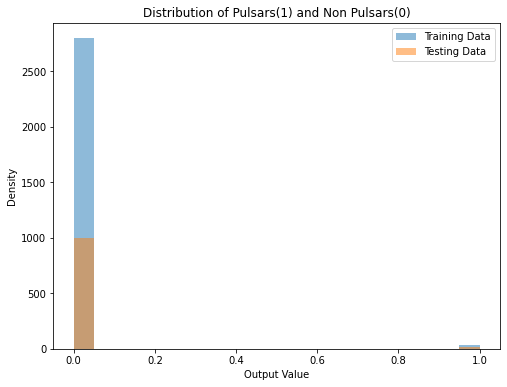

In [25]:
#dataset_source = "HTRU"
dataset_source ="LOTAAS"

X_train, X_valid, X_test, y_train, y_valid, y_test, input_columns = load_dataset(dataset_source)

plot_output_distribution(y_train, y_test)

X_train, X_valid= preprocess_data(X_train,X_valid,input_columns)

X_train, y_train = balance_dataset(X_train,y_train)
X_valid, y_valid = balance_dataset(X_train,y_train)

X_train = X_train.values
X_valid = X_valid.values
X_test = X_test.values

y_valid = np.array(y_valid)
y_train = np.array(y_train)  
y_test = np.array(y_test)

In [26]:
model_ann,history= ann_one_output_node(X_train,y_train,X_valid,y_valid)

Test Accuracy: 99.21%
Test Precision: 100.00%


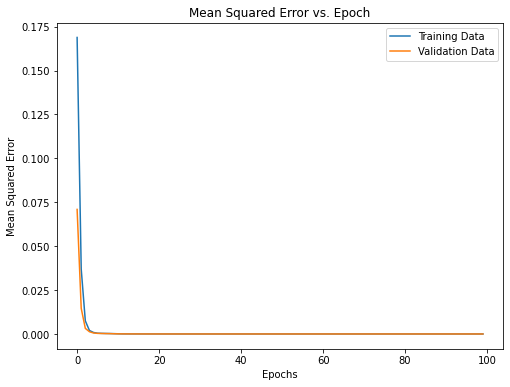

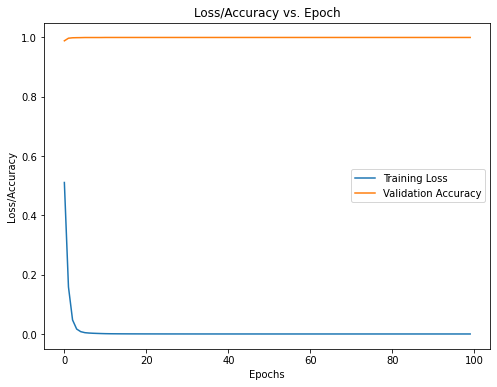

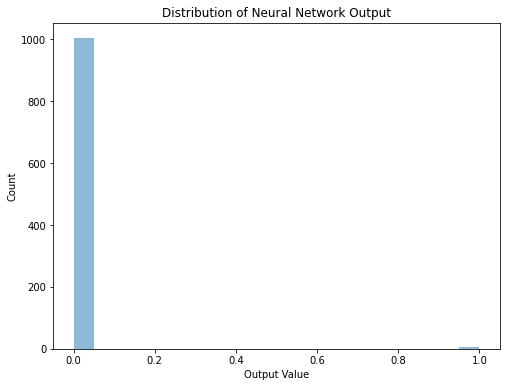

In [27]:
model_metrics(X_test, y_test, model_ann)

plot_mse_epoch(history)

plot_training_loss_validation_accuracy(history)

plot_predictions_dist_pulsars_nonpulsars(X_test, y_test, model_ann)